In [1]:
##to check if GPU is working

import tensorflow as tf; 
print(tf.config.list_physical_devices('GPU'))

2023-04-20 08:42:06.550166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 08:42:06.616338: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-20 08:42:06.633710: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-20 08:42:06.996060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-20 08:42:08.694302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 08:42:08.712800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 08:42:08.712946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
## Importing the required libraries

import random
import  time
import os
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow.compat.v1 as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint





In [3]:
##Data stored in folder format
# key: 'name' shows the name of different scenarios
# key: 'number_of_videos' describes the number of videos in each scenario

dict = {'name': ['bookstore', 'coupa', 'deathCircle', 'gates', 'hyang', 'little', 'nexus', 'quad'],
        'number_of_videos': [7, 4, 5, 9, 15, 4, 12, 4]}

column_header = ['Track_ID','x_min','y_min','x_max','y_max','frame','lost','occluded','generated','label']
df2 = pd.DataFrame()

#creating a big dataset with scenario having highest no. of videos
for j in range(dict['number_of_videos'][4]):
    current_file= pd.read_csv(f'/home/shefali/Downloads/annotations/hyang/video{j}/updated.csv')
    x_feature = (current_file.iloc[:,1:5]) #only Bounding Box value extracted
    df2 = pd.concat([df2,x_feature])
print(df2)


       x_min  y_min  x_max  y_max
0        763    557    776    597
1        763    557    776    597
2        763    557    776    597
3        763    557    776    597
4        763    557    776    597
...      ...    ...    ...    ...
33071    880    487    913    518
33072    880    487    913    518
33073    880    487    913    518
33074    880    487    913    518
33075    882    489    913    520

[2326629 rows x 4 columns]


In [4]:
## feature scaling

ss = StandardScaler()
sc = MinMaxScaler(feature_range=(0,1))
scaled_x_ft = sc.fit_transform(df2.values)
x_fet = ss.fit_transform(df2.values)
##MinMax scaled feature used
scaled_x_ft = pd.DataFrame(columns= df2.columns,data=scaled_x_ft,index=df2.index)
print(f'MinMaxScaled:{scaled_x_ft}') 


x_fet = pd.DataFrame(columns= df2.columns,data=x_fet,index=df2.index)
print(x_fet)

MinMaxScaled:          x_min     y_min     x_max     y_max
0      0.528028  0.281171  0.531444  0.296836
1      0.528028  0.281171  0.531444  0.296836
2      0.528028  0.281171  0.531444  0.296836
3      0.528028  0.281171  0.531444  0.296836
4      0.528028  0.281171  0.531444  0.296836
...         ...       ...       ...       ...
33071  0.608997  0.245835  0.626123  0.257157
33072  0.608997  0.245835  0.626123  0.257157
33073  0.608997  0.245835  0.626123  0.257157
33074  0.608997  0.245835  0.626123  0.257157
33075  0.610381  0.246845  0.626123  0.258162

[2326629 rows x 4 columns]
          x_min     y_min     x_max     y_max
0      0.120633 -0.187117  0.050816 -0.208751
1      0.120633 -0.187117  0.050816 -0.208751
2      0.120633 -0.187117  0.050816 -0.208751
3      0.120633 -0.187117  0.050816 -0.208751
4      0.120633 -0.187117  0.050816 -0.208751
...         ...       ...       ...       ...
33071  0.429145 -0.335509  0.413331 -0.372892
33072  0.429145 -0.335509  0.413331 -0.

In [5]:
##function takes the entire data and creates windows of size n_steps

def lstm_split(data,n_steps):
    # for each time step, LSTM will take n_steps-1 samples for training and predict the last sample.
    X,y = [], []
    for i in range(len(data)-n_steps+1):
        X.append(data[i:i+n_steps,:])
        #print('X:',X)
        y.append(data[i+n_steps-1,:])
        #print('y:',y)
    return np.array(X),np.array(y)


In [6]:
##creating train and test dataset
#we pass the entire dataset to the lstm_split()
X1,y1= lstm_split(scaled_x_ft.values,n_steps=15)
print(scaled_x_ft.values)

#split the input and output based on index
train_split=0.8
split_idx = int(np.ceil(len(X1)*train_split))

X_train, X_test = X1[:split_idx], X1[split_idx:]
print('X_train:',X_train.shape)
print('X_test:',X_test.shape)
y_train ,y_test = y1[:split_idx], y1[split_idx:]
X_train_date , X_test_date =date_index[:split_idx],date_index[split_idx:]
print('y_test:',y_test.shape)


[[0.52802768 0.28117113 0.53144437 0.29683576]
 [0.52802768 0.28117113 0.53144437 0.29683576]
 [0.52802768 0.28117113 0.53144437 0.29683576]
 ...
 [0.60899654 0.24583544 0.62612301 0.25715721]
 [0.60899654 0.24583544 0.62612301 0.25715721]
 [0.61038062 0.24684503 0.62612301 0.25816173]]
1861292
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            33066, 33067, 33068, 33069, 33070, 33071, 33072, 33073, 33074,
            33075],
           dtype='int64', length=2326629)
X_train: (1861292, 15, 4)
X_test: (465323, 15, 4)
y_test: (465323, 4)
X_train_date: (1861292,) X_test_date: Int64Index([125543, 125544, 125545, 125546, 125547, 125548, 125549, 125550,
            125551, 125552,
            ...
             33066,  33067,  33068,  33069,  33070,  33071,  33072,  33073,
             33074,  33075],
           dtype='int64', length=465337)


In [ ]:
##Model architecture design

model =Sequential()
model.add(LSTM(50,input_shape=(X_train.shape[1],X_train.shape[2]),activation='tanh',return_sequences = True))
model.add(LSTM(50,activation='tanh'))
model.add(Dense(4))
model.compile(loss='mean_squared_error',optimizer='adam')
#model training
history = model.fit(X_train,y_train,epochs=20,batch_size=4,verbose=2,shuffle=False)


##Saving the trained model
model.save("Saved_trained_model")

2023-04-04 14:44:00.335391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 14:44:00.336366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 14:44:00.336596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 14:44:00.336697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

In [7]:
##to load the SavedModel

new_model = load_model("Saved_trained_model")

2023-04-20 08:42:25.690516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 08:42:25.692083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 08:42:25.692224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 08:42:25.692284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

In [19]:
##Test set created based on Stanford public dataset

y_pred = new_model.predict(X_test)

rmse = mean_squared_error(y_test,y_pred,squared=True)
mape = mean_absolute_error(y_test,y_pred)
print('Root mean sqaure error:',rmse)
print('Mean absolute error:',mape)


14542/14542 [==============================] - 25s 2ms/step
(465323, 4)
(465323, 4)
Root mean sqaure error: 0.0018179831254175583
Mean absolute error: 0.028256151975258815


In [17]:
predicted_value = pd.DataFrame(y_pred)
test_dataset = pd.DataFrame(y_test)

               0         1         2         3
0       0.383601  0.225621  0.414599  0.236553
1       0.385370  0.225753  0.416335  0.236658
2       0.385468  0.225591  0.416421  0.236502
3       0.387174  0.225794  0.418092  0.236680
4       0.387162  0.225675  0.418069  0.236570
...          ...       ...       ...       ...
465318  0.610471  0.260254  0.635804  0.268551
465319  0.610471  0.260254  0.635804  0.268551
465320  0.610471  0.260254  0.635804  0.268551
465321  0.610471  0.260254  0.635804  0.268551
465322  0.611149  0.261471  0.636453  0.269773

[465323 rows x 4 columns]


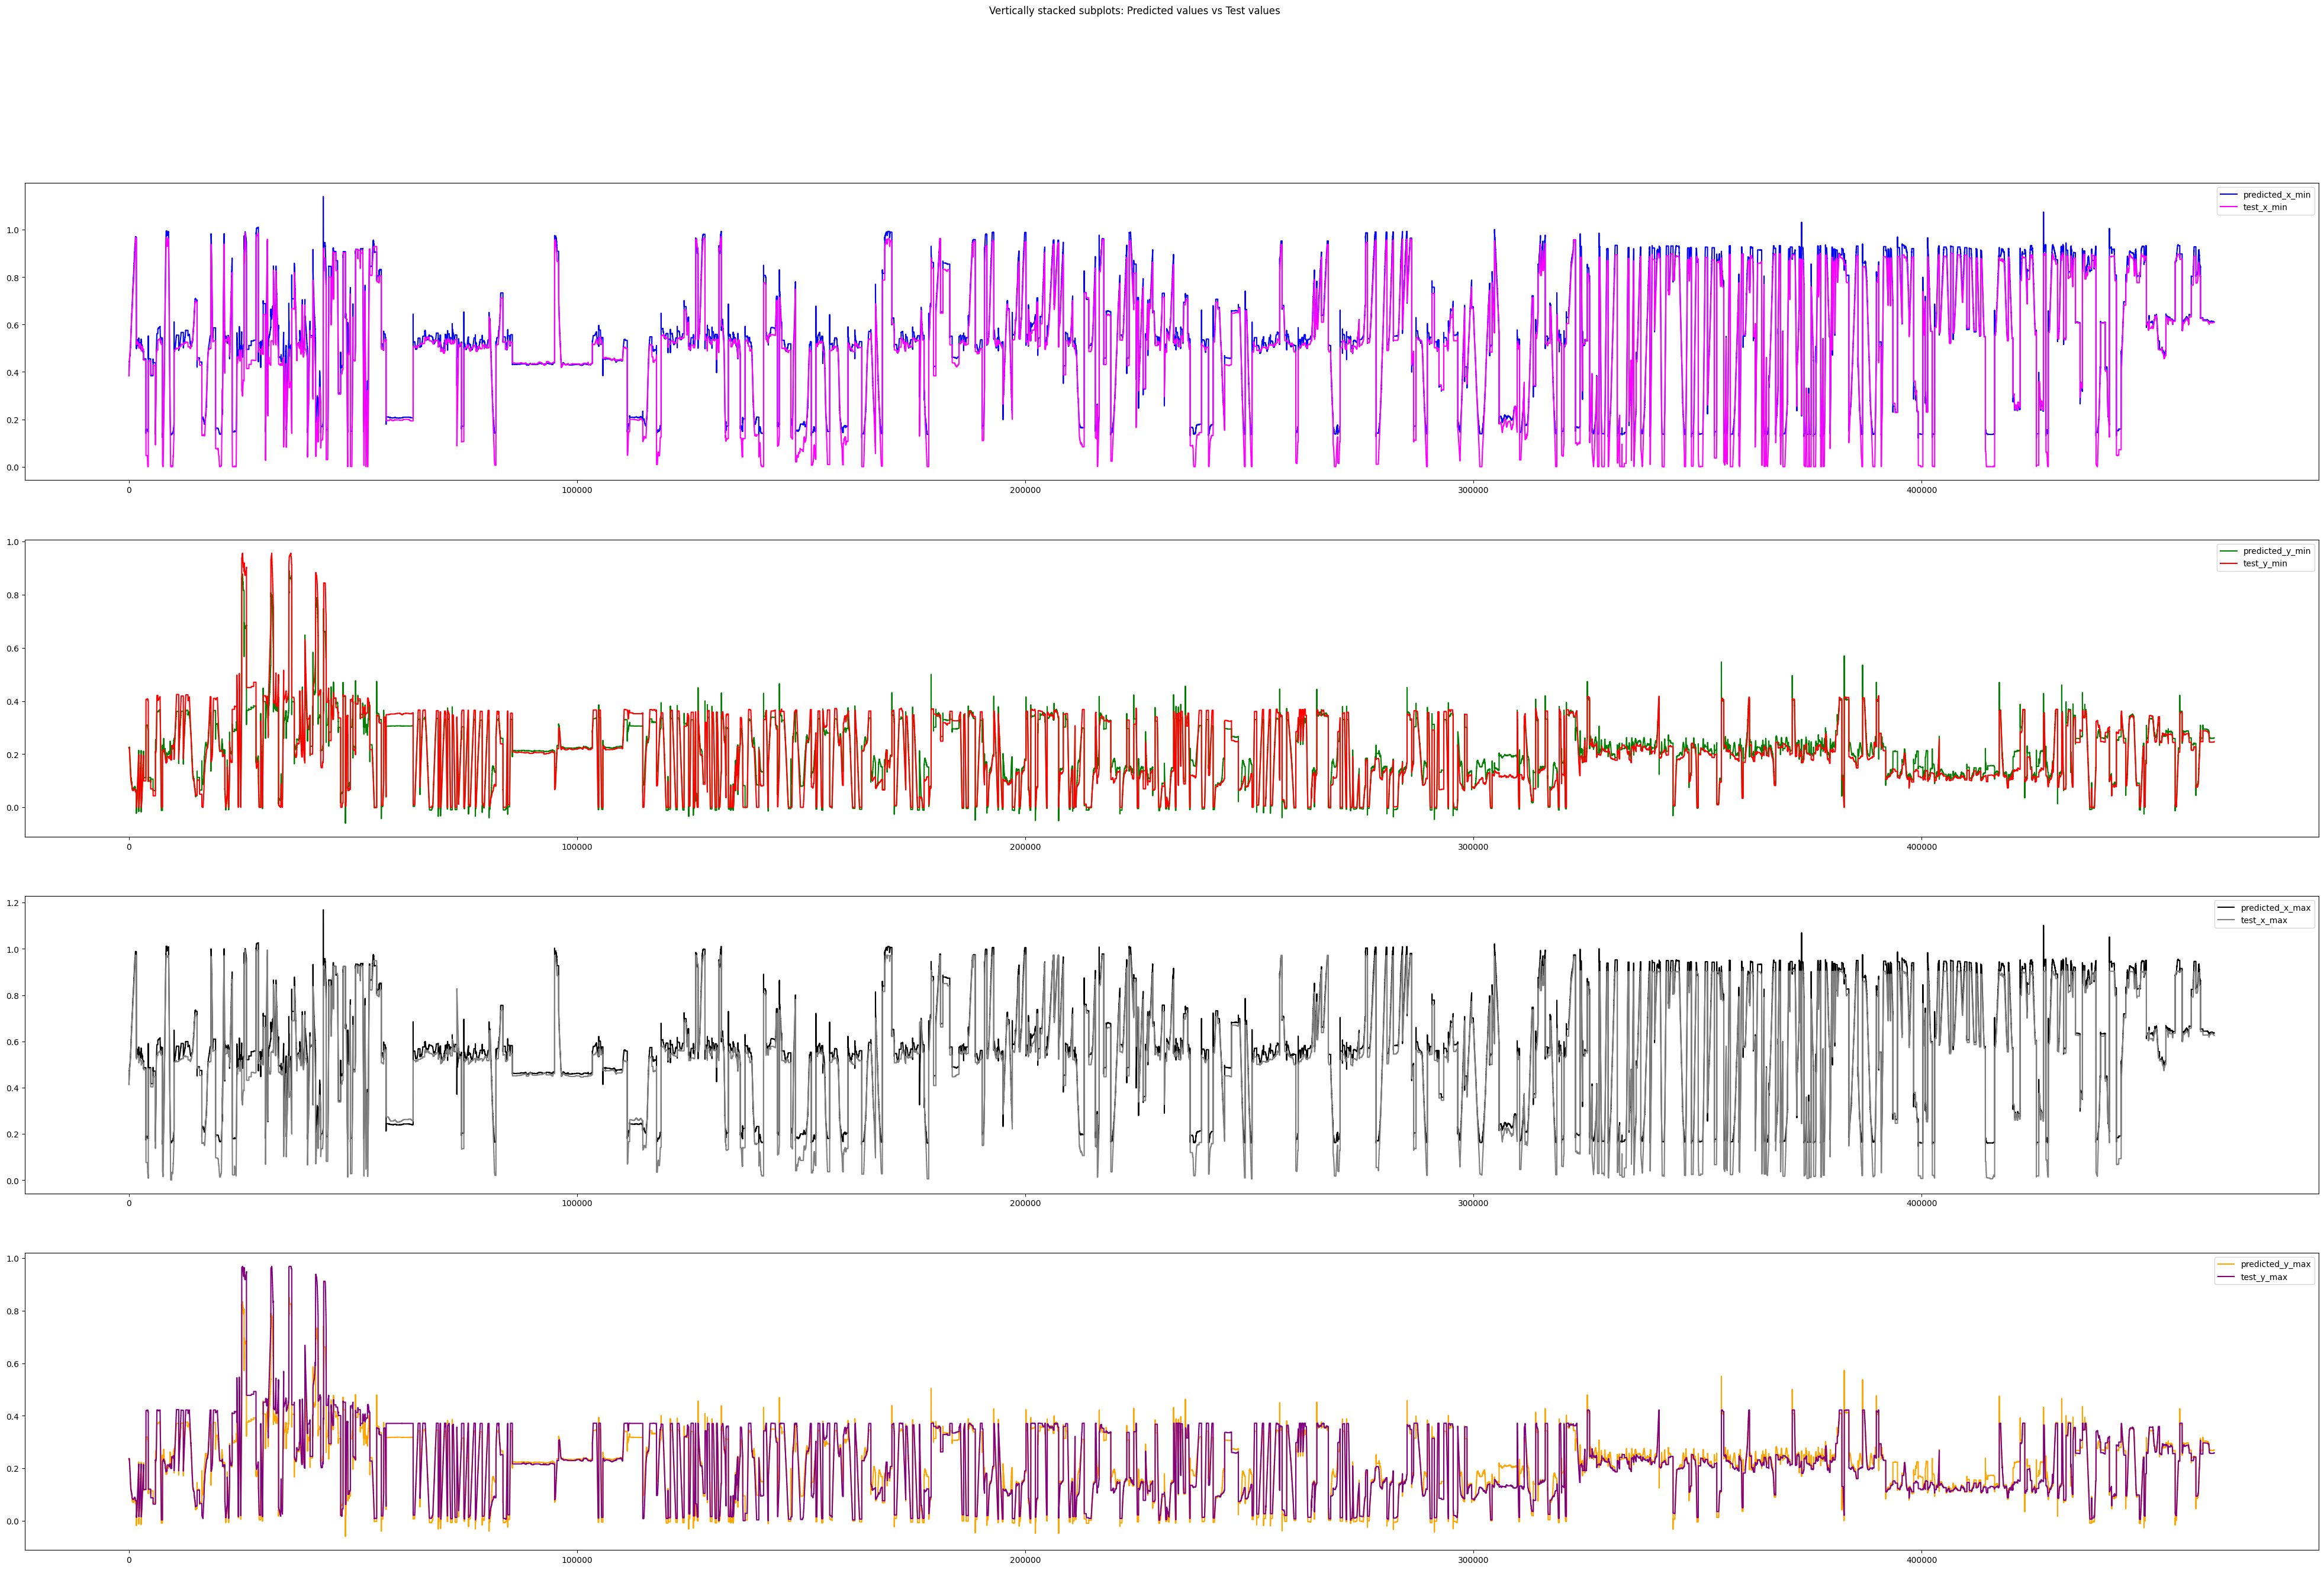

In [18]:
## to visulaize the line graph

fig,axs = plt.subplots(4,figsize=(50,30))

fig.suptitle('Vertically stacked subplots: Predicted values vs Test values')
predicted_x_min = axs[0].plot(predicted_value[0],color='blue',label ='predicted_x_min')
predicted_y_min = axs[1].plot(predicted_value[1],color = 'green',label ='predicted_y_min')
predicted_x_max = axs[2].plot(predicted_value[2],color= 'black',label ='predicted_x_max')
predicted_y_max = axs[3].plot(predicted_value[3],color='orange',label ='predicted_y_max')
test_x_min = axs[0].plot(test_dataset[0],color='magenta',label='test_x_min')
test_y_min = axs[1].plot(test_dataset[1],color = 'red',label='test_y_min')
test_x_max = axs[2].plot(test_dataset[2],color= 'gray',label='test_x_max')
test_y_max = axs[3].plot(test_dataset[3],color='purple',label='test_y_max')

axs[0].legend(loc = 'upper right')
axs[1].legend(loc = 'upper right')
axs[2].legend(loc = 'upper right')
axs[3].legend(loc = 'upper right')

In [46]:
##Test set generated out of SMART2 images for Inference

## object 1: DJI_0003

X_test_generated = [[1723, 193, 9, 15],[1705, 250, 10, 18],[1694, 324, 11, 20],[1699, 419, 14, 25],
                    [1716, 561, 13, 31],[1752, 805, 14, 37],[1766, 1278, 26, 46],[1767, 1727, 34, 56],
                    [1705, 1718, 35, 63],[1760, 2020, 34, 71]]

                
X_test_df = pd.DataFrame(X_test_generated)
print(X_test_df)

## feature scaling
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test_df.to_numpy())

X_test_scaled = pd.DataFrame(data= X_test_scaled, columns=X_test_df.columns)
#print(X_test_scaled)

      0     1   2   3
0  1723   193   9  15
1  1705   250  10  18
2  1694   324  11  20
3  1699   419  14  25
4  1716   561  13  31
5  1752   805  14  37
6  1766  1278  26  46
7  1767  1727  34  56
8  1705  1718  35  63
9  1760  2020  34  71


In [13]:
## to create a function to take 5 values and interpolate it to return 15 values
''' this function is required 
as each sequence of image for 
Inference doesn't have exactly 15 values'''

def interpolate_df(df,min_count, max_count):
    interpolated_df = pd.DataFrame()
    b_interpolated_df = pd.DataFrame()
    for i in range(len(df.columns)):
        y_idx = np.array(df[i])
        x_idx = np.arange(0,len(df))
        val = np.linspace(0,min_count,max_count)

        f = interpolate.interp1d(x_idx,y_idx)
        b = interpolate.BarycentricInterpolator(x_idx,y_idx)
        interpolated_df[i]=f(val)
        b_interpolated_df[i] = b(val)
    return interpolated_df,b_interpolated_df


interpolated_df,b_interpolated_df = interpolate_df(X_test_df,len(X_test_df)-1,15)
print(interpolated_df)
print(b_interpolated_df)
    

         0      1      2     3
0   2171.0  166.0   37.0  16.0
1   1994.0  167.0   38.0  15.0
2   1965.0  181.0   41.0  17.0
3   1952.0  203.0   43.0  19.0
4   1944.0  240.0   48.0  21.0
5   1927.0  295.0   54.0  23.0
6   1925.0  359.0   61.0  26.0
7   1927.0  397.0   65.0  27.0
8   1927.0  438.0   70.0  31.0
9   1927.0  486.0   75.0  34.0
10  1929.0  544.0   82.0  36.0
11  1932.0  599.0   89.0  38.0
12  1934.0  642.0   95.0  44.0
13  1936.0  672.0   98.0  46.0
14  1936.0  684.0  100.0  46.0
         0      1      2     3
0   2171.0  166.0   37.0  16.0
1   1994.0  167.0   38.0  15.0
2   1965.0  181.0   41.0  17.0
3   1952.0  203.0   43.0  19.0
4   1944.0  240.0   48.0  21.0
5   1927.0  295.0   54.0  23.0
6   1925.0  359.0   61.0  26.0
7   1927.0  397.0   65.0  27.0
8   1927.0  438.0   70.0  31.0
9   1927.0  486.0   75.0  34.0
10  1929.0  544.0   82.0  36.0
11  1932.0  599.0   89.0  38.0
12  1934.0  642.0   95.0  44.0
13  1936.0  672.0   98.0  46.0
14  1936.0  684.0  100.0  46.0


In [14]:
interpolated_df_scaled = scaler.fit_transform(interpolated_df.to_numpy())
interpolated_df_scaled = pd.DataFrame(data= interpolated_df_scaled, columns=interpolated_df.columns)


## Evaluation on Inference data
X4,y4= lstm_split(interpolated_df_scaled.values,n_steps=15)
y_pred4 = new_model.predict(X4)
print("predicted value:",y_pred4)
print("Ground truth:",y4)
rescaled_val = scaler.inverse_transform(y_pred4)
rescaled_y_val = scaler.inverse_transform(y4)

print(f'rescaled  value : {rescaled_val}')
print(f'rescaled y value : {rescaled_y_val}')
rmse4 = mean_squared_error(y4,y_pred4,squared=True)
mape4 = mean_absolute_error(y4,y_pred4)
print('Root mean sqaure error:',rmse4)
print('Mean absolute error:',mape4)

predicted_value4 = pd.DataFrame(y_pred4)
test_dataset4 = pd.DataFrame(y4)


1/1 [==============================] - 0s 25ms/step
predicted value: [[0.58724433 0.8456947  0.6071583  0.8199563 ]]
Ground truth: [[0.04471545 1.         1.         1.        ]]
rescaled  value : [[2069.4622    604.0699     75.25098    40.418648]]
rescaled y value : [[1936.  684.  100.   46.]]
Root mean sqaure error: 0.12622201039386347
Mean absolute error: 0.31742988950837914
